<a href="https://colab.research.google.com/github/tescalada/time-guide/blob/master/solar_clock_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install sidecar
!pip install skyfield
!pip install timezonefinder[numba]
!pip install ipycanvas
!pip install time-machine

     |████████████████████████████████| 391 kB 4.1 MB/s 
     |████████████████████████████████| 40 kB 5.2 MB/s 
     |████████████████████████████████| 258 kB 43.6 MB/s 
  Created wheel for skyfield: filename=skyfield-1.42-py3-none-any.whl size=436509 sha256=2159c7727711c399608f65dcd91c4a837dda6c963b0bedf63f9818ec9510b438
  Stored in directory: /root/.cache/pip/wheels/f8/37/bb/01a58b55ad1551ff4828713f195fd20c4c0a58f76504684727
  Created wheel for jplephem: filename=jplephem-2.17-py3-none-any.whl size=46328 sha256=958cc8efd3d02e17f1e7cf6afe8f5c563821b85a8491ee99d762427ec900ed32
  Stored in directory: /root/.cache/pip/wheels/6c/fe/9c/2b3a1f7d639f9833f5cd79a2e62cb5d6f7901ee731e6cfd6e1
Successfully built skyfield jplephem
     |████████████████████████████████| 43.0 MB 2.7 MB/s 
     |████████████████████████████████| 253 kB 3.7 MB/s 


In [ ]:
# Setting the local timezone in the jupyter environment, this is probably not necessary on the pi as it should share the timezone with the pi
import os 
import time
os.environ['TZ'] = 'UTC'
time.tzset()

In [ ]:
import math
import numpy as np
from PIL import Image
from io import BytesIO
import base64
from IPython.display import clear_output, display, HTML, Javascript, Image as DImage
#from sidecar import Sidecar
import datetime


import ipywidgets as widgets
import logging

class OutputWidgetHandler(logging.Handler):
    """ Custom logging handler sending logs to an output widget """

    def __init__(self, *args, **kwargs):
        super(OutputWidgetHandler, self).__init__(*args, **kwargs)
        layout = {
            'width': '100%',
            'height': '160px',
            'border': '1px solid black'
        }
        self.out = widgets.Output(layout=layout)

    def emit(self, record):
        """ Overload of logging.Handler method """
        formatted_record = self.format(record)
        new_output = {
            'name': 'stdout',
            'output_type': 'stream',
            'text': formatted_record+'\n'
        }
        self.out.outputs = (new_output, ) + self.out.outputs
        #self.show_logs()

    def show_logs(self):
        """ Show the logs """
        display(self.out)

    def clear_logs(self):
        """ Clear the current logs """
        self.out.clear_output()


logger = logging.getLogger(__name__)
handler = OutputWidgetHandler()
handler.setFormatter(logging.Formatter('%(asctime)s  - [%(levelname)s] %(message)s'))
logger.addHandler(handler)
logger.setLevel(logging.INFO)


##handler.show_logs()




def rgbw_to_rgb(pixel_value):
    """This takes a (r,g,b,w) input value and returns a (r,g,b) value."""
    # fix for RGBW not working with png and the code currently not using any colors
    r, g, b, w = pixel_value
        
    if r+g+b == 0:
        # if rgb is all 0 then just use the w component for the rgb values across the board
        pixel_value = [w, w, w]
    else:
        # otherwise increase the rgb values equally by the W percentage
        w_pct = w/256.0
        pixel_value = (
            int(max(255, r * w_pct)),
            int(max(255, g * w_pct)),
            int(max(255, b * w_pct)),
        )

    if w > 0 :
        pixel_value = [255,0,0]
    else:
        pixel_value = [0,0,0]
        
    return pixel_value



class PNGPixel(object):
    
    def __init__(self, scale=25, width=9, height=9, display_id='displayid'):
        self.scale = scale
        self.sc = Sidecar(title='Solar Clock Display')
        self.width = width
        self.height = height
        self.display_id = display_id
        # the png pixels are only RGB vs RGBW like the neopixel, so they only have 3 values
        #self.pixels = np.zeros([self.height, self.width, 3], dtype=np.uint8)
        #self.pixels_linear = self.pixels.reshape(self.height * self.width, 1, 3)
        self.dh = display(display_id=True)
    
    #def __setitem__(self, linear_position, pixel_value):
    #    self.pixels_linear[linear_position][0] = rgbw_to_rgb(pixel_value)
        
    def show(self, img, extra=None):
        with self.sc:
            img_str = str(base64.b64encode(img.getvalue()), encoding="ascii")
            h = HTML(f'''
                <img src="data:image/png;base64,''' + img_str + '''" width="400" height="400" ></img>
                <div>''' + str(extra) + '''</div>
            ''')
            
            clear_output(wait=True)
            
            i = DImage(
                data=None, 
                url='data:image/png;base64,' + img_str, 
                filename=None, 
                format=None, 
                embed=None, 
                width=self.width * self.scale, 
                height=self.height * self.scale, 
                retina=False, 
                unconfined=False, 
                metadata=None
            )
            
            self.dh.display(h)

    
# Hardware Types:
# CLOCK:
# the clock hardware displays the output using the neopixels in the solsysclock hardware

# VIRTUAL:
# the virtual hardware displays the output as a png


class SolSysClock(object):
    
    def __init__(self, hardware='CLOCK'):
        
        self.width = 9
        self.height = 9
        self.hardware = hardware
        
        if hardware == 'CLOCK':
            import board
            from neopixel import NeoPixel, RGBW
            #initialize neopixel
            pixel_pin = board.D18
            n = self.width * self.height
            self.output = NeoPixel(pixel_pin, n, brightness=1, pixel_order=RGBW)
        else: 
            # default to virtual display if no valid hardware is selected
            self.output = PNGPixel(width=self.width, height=self.height)
        
        # sets self.pixels to (0,0,0,0) for every pixel in a (9,9) matrix
        self.clear()
        
    def clear(self):
        """Turn off all the pixels."""
        self.pixels = np.zeros([self.height, self.width, 4], dtype=np.uint8)
    
    def __setitem__(self, xy_coord, pixel_value):
        x, y = xy_coord
        self.pixels[x,y] = pixel_value
        
    def __repr__(self):
        return str(self.pixels)
        
    def write(self):
        self.show()
        
    def show(self, *args, **kwargs):
        """Write pixel values to the display."""
        # TODO probably a better numpyish way of doing this
        
        if self.hardware == 'CLOCK':
            # TODO: flip all the odd rows before sending to the neopixel
            for linear_pixel, pixel in enumerate(self.pixels.reshape(self.height * self.width,1,4)):
                self.output[linear_pixel] = pixel[0]
            self.output.show()
        elif self.hardware == 'VIRTUAL':
            # Take any args or kwargs and pass them to the show command to be displayed under the clock visualization
            extra = ''
            for arg in args:
                extra += f'<div>{arg}</div>'
            for key, value in kwargs:
                extra += f'<div>{key}: {value}</div>'           
            
            self.output.show(
                img=self.to_PNG(), 
                extra=extra,
            )
            
    def clear_row(self, row):
        self.pixels[row,:] = [0, 0, 0, 0]

    def to_PNG(self, output_filename=None):
        #print(self.pixels)
        # rotate the pixels 90 degrees
        data = np.rot90(self.pixels)
        
        # flip horizontal
        #data = np.fliplr(data)

        # get the dimentions of our multidimentional numpy array
        # x = height
        # y = width
        x, y = data.shape[0], data.shape[1]

        # reshape the grid so it is a single line of pixels instead of a grid
        data = data.reshape(x * y, 4)

        # convert from RGBW to RGB across the flat array (faster than operating on the grid)
        # This function will convert the Z axis from 4 to 3 values so it can be rendered as a png
        pixels = np.apply_along_axis(rgbw_to_rgb, 1, data)

        # reshape back to the grid of pixels that is an image
        pixels = pixels.reshape(x, y, 3)

        # create an image from our numpy array of RGB pixel data        
        pixels = pixels.astype(np.uint8)
        im = Image.fromarray(pixels)

        if output_filename:
            output = None
            raise NotImplemented("saving to a file is not yet implemented!")
        else:
            output = BytesIO()

        im.save(output, format="PNG")
        # TODO: should this return just the buffer, or should it return the image?
        return output

    def _repr_png_(self):
        """iPython display hook support

        :returns: png version of the image as bytes
        """
        return self.to_PNG().getvalue()


    


I should switch the code to create the virtual image on demand, and to send the led commands if the led hardware is present. That way both work at the same time if this code is running on the pi. Then you could have a web interface to see what the leds are doing remotely. 

Then the jupyter ui could just be displaying that backends web image whenever the call is made to update the view.

we jupyter ui could also be pulling from the log file the last X logs of Y level to display

There could also be a web interface showing the same thing on a debugging page



In [ ]:
import time
import datetime
import logging
from datetime import timezone, timedelta
import numpy
import json
from skyfield.api import N, W, wgs84, load, utc
from skyfield.almanac import find_discrete, risings_and_settings
from dateutil import tz

from timezonefinder import TimezoneFinder


global LOCAL_TZ

DEBUGGING = True

if DEBUGGING:
    # take control of time so we can manually tick time forward instead of suffering the passage of time
    import time_machine
    freezer = time_machine.travel(datetime.datetime.now(timezone.utc), tick=True)
    frozen_time = freezer.start()

#initialize log

logger = logging.getLogger(__name__)
handler = OutputWidgetHandler()
handler.setFormatter(logging.Formatter('%(asctime)s  - [%(levelname)s] %(message)s'))
logger.addHandler(handler)
logger.setLevel(logging.INFO)


def read_config():
    try:
        with open('config.json') as json_file:
            config_data = json.load(json_file)
    except:
        config_data = {
            "lat": 42.671041821329844, 
            "lon": 71.50191599339404,
        }
    return config_data

def planet_timestamp(name, action, ts, planets, city, eph, names):
    logger.info('%s %s' % (name, action))
    # this function returns the next rise or set time from now
    t0 = datetime.datetime.now(timezone.utc)
    logger.info('t0: %s' % t0)
    # make hours 24+1 because during spring, next sunset will be more than 24h later than current
    t1 = t0 + datetime.timedelta(hours=25)
    logger.info('t1: %s' % t1)

    # t0 = t0.replace(tzinfo=utc)
    t0 = ts.utc(t0)
    # t1 = t1.replace(tzinfo=utc)
    t1 = ts.utc(t1)

    f = risings_and_settings(eph, planets[names.index(name)], city)
    #This returns a function taking a Time argument returning True if the body’s altazimuth altitude angle plus radius_degrees is greater than horizon_degrees, else False
    t, values = find_discrete(t0, t1, f)
    #Find the times at which a discrete function of time changes value. in this case, find the set (0) and rise (1) times, t.

    if action == 'rise':
        #values array is 1 for the rise. we look up the index of the rise in the time array, t, to get the time of the rise event.
        timestamp = t[numpy.where(values == 1)].utc_datetime()
        logger.info('timestamp: %s' % timestamp)
    else:
        #values array is 0 for the set. we look up the index of the set in the time array, t, to get the time of the set event.
        timestamp = t[numpy.where(values == 0)].utc_datetime()
        logger.info('timestamp: %s' % timestamp)

    timestamp = timestamp[0].timestamp()
    #handler.show_logs()
    return int(timestamp)

def make_planet_list(ts, planets, city, eph, names):
    rise = [[0 for i in range(3)] for j in range(len(names))]
    sett = [[0 for i in range(3)] for j in range(len(names))]
    for i, name in enumerate(names):
        # obtain the next rise time
        rise[i][0] = planet_timestamp(name, 'rise', ts, planets, city, eph, names)
        rise[i][1] = name
        rise[i][2] = 'rise'

        logger.info('acquired: %s, %s, rise' % (rise[i][0], name))

        # obtain the next set time
        sett[i][0] = planet_timestamp(name, 'sett', ts, planets, city, eph, names)
        sett[i][1] = name
        sett[i][2] = 'sett'

        logger.info('acquired: %s, %s, sett' % (sett[i][0], name))

    rise = [tuple(l) for l in rise]
    sett = [tuple(l) for l in sett]
    planet_list = rise + sett
    #handler.show_logs()
    return planet_list


def format_planet_list(planet_list):
    result = ""
    
    for ts, planet, event in planet_list:
        dt = datetime.datetime.fromtimestamp(ts)
        result += f'{local_time(dt)} {planet} {event}\n<br/>'
    return result

def local_time(dt):
    return dt.replace(microsecond=0).replace(tzinfo=tz.gettz('UTC')).astimezone(LOCAL_TZ)
    


def run_clock():
    #initialize skyfield stuff
    eph = load('de421.bsp')
    sun = eph['sun']
    moon = eph['moon']
    mercury = eph['mercury']
    venus  = eph['venus']
    earth  = eph['earth']
    mars = eph['mars']
    jupiter = eph['JUPITER BARYCENTER']
    saturn = eph['SATURN BARYCENTER']
    uranus = eph['URANUS BARYCENTER']
    neptune = eph['NEPTUNE BARYCENTER']
    planets = [sun,
               moon,
               mercury,
               venus,
               mars,
               jupiter,
               saturn,
               uranus,
               neptune]
    ts = load.timescale()

    # define variables
    # lat = 38.9072
    # lon = 77.0369
    config_data = read_config()
    #define city just by lat/lon for almanac lookup
    city = wgs84.latlon(float(config_data['lat']) * N, float(config_data['lon']) * W)
    
    # find the local timezone based on the coordinates provided
    # TODO: move this into the code where the coordinates are saved 
    # instead so we can just read the timezone from the config file
    global LOCAL_TZ
    tf = TimezoneFinder()
    LOCAL_TZ = tz.gettz(tf.timezone_at(lng=float(config_data['lon']) * W, lat=float(config_data['lat']) * N))

    names = ['sun', 'moon', 'mercury', 'venus', 'mars', 'jupiter', 'saturn', 'uranus', 'neptune']

    #initialize hardware
    ssc = SolSysClock(hardware='VIRTUAL')
    ssc.clear()
    ssc.show(local_time(datetime.datetime.now(timezone.utc)))

    n = ssc.width * ssc.height
    # LED list for each light
    LED = [
        (0, 0, 0, 25),
        (0, 0, 0, 25),
        (0, 0, 0, 25),
        (0, 0, 0, 25),
        (0, 0, 0, 25),
        (0, 0, 0, 25),
        (0, 0, 0, 25),
        (0, 0, 0, 25),
        (0, 0, 0, 25)
    ]

    now = int(time.time()) # return time since the Epoch
    logger.info('current unix timestamp: %s' % now)
    now_local = time.localtime(now)
    now_local_str = " ".join(map(str, now_local))

    logger.info('local time string: %s' % now_local_str)

    planet_list = make_planet_list(ts, planets, city, eph, names)
    list.sort(planet_list)

    ssc.clear()
    ssc.show(local_time(datetime.datetime.now(timezone.utc)), format_planet_list(planet_list))
    #handler.show_logs()
    time.sleep(0.5)
    
    for i in range(len(names)):

        time.sleep(0.5)

        #turn on LEDs for planets already above horizon
        if planet_list[i][0] > planet_list[i + 9][0]: # if rise time is later than set time, it's above the horizon
            logger.info(f'above horizon: {planet_list[i][1]}')

            dur_rem = planet_list[i + 9][0] - now #find time remaining until set
            dur = (24 * 3600) - (planet_list[i][0] - planet_list[i + 9][0]) #find approximate total time above horizon
            dur_int = int(dur / (2 * (n / len(names)) - 1)) #find duration of a single timestamp interval
            int_rem = int(dur_rem / dur_int) # number of intervals remaining is the duration remaining divided by duration interval
            if int_rem > 17:
                int_rem = 17

            dur_int_rem = dur % dur_int #remainder of time in final interval
            logger.info(f'duration remaining: {dur_rem}')
            logger.info(f'intervals remaining: {int_rem}')

            timestamp, planetname, action = planet_list[i + 9]

            #if the planet is setting:
            if int_rem < (n / len(names)) and not int_rem == 0:
                # 1. find a_set timestamps
                for j in range(int_rem - 1):
                    above_set_timestamp = int(timestamp - ((dur_int * (j + 1)) + dur_int_rem))
                    above_set_tuple = (above_set_timestamp, planetname, 'a_set')
                    planet_list.append(above_set_tuple)

                # 2. light up last int_rem LEDs for setting
                for j in range(int_rem):
                    ssc[i, j] = LED[j]
                    ssc.show(local_time(datetime.datetime.now(timezone.utc)), format_planet_list(planet_list))
            elif int_rem == 0: #if the planet is about to set, light up last LED only
                ssc[i, 0] = LED[0]
                ssc.show(local_time(datetime.datetime.now(timezone.utc)), format_planet_list(planet_list))

            # if the planet is rising:
            else:
                #1. find a_rise timestamps
                for j in range(int_rem - int(n / len(names))):
                    above_rise_timestamp = int(timestamp - (int((n / len(names)) - 1) * dur_int + dur_int * (j + 1) + dur_int_rem))
                    above_rise_tuple = (above_rise_timestamp, planetname, 'a_rise')
                    planet_list.append(above_rise_tuple)
                #2. find a_set timestamps
                for j in range(int(n / len(names) - 1)):
                    above_set_timestamp = int(timestamp - (dur_int * (j + 1) + dur_int_rem))
                    above_set_tuple = (above_set_timestamp, planetname, 'a_set')
                    planet_list.append(above_set_tuple)
                #3. light up LEDs
                for j in range(2 * int(n / len(names)) - int_rem):
                    ssc[i, ssc.height - (j + 1)] = LED[j]
                    ssc.show(local_time(datetime.datetime.now(timezone.utc)), format_planet_list(planet_list))

    list.sort(planet_list) #sort list of rise and set chronologically
    logger.debug('planet_list: %s' % planet_list)
    #handler.show_logs()

    while True:
        timestamp, planetname, action = planet_list.pop(0)
        timestamp_local = time.localtime(timestamp)
        timestamp_local_str = " ".join(map(str, timestamp_local))
        logger.info('next up: planet: %s' % planetname)
        logger.info('next up: action: %s' % action)
        logger.info('next up: unix timestamp: %s' % timestamp)
        logger.info('next up: local event time: %s' % timestamp_local_str)
        
        planet_num = names.index(planetname)

        #sleep until the action
        delay = timestamp - now
        logger.info('delay is: %s' % delay)

        if delay > 0:
            if DEBUGGING:
                # jump the clock forward in time by the value of delay - 1 and then wait only 1 second
                frozen_time.shift(delta=delay - 1)
                delay = 1
                
            # sleep until timestamp
            time.sleep(delay)
            
        if action == 'rise':
            logger.info('action is: %s' % action)

            #part 1: create list of above horizon intervals to adjust LEDs
            dur = [item for item in planet_list if planetname in item][0][0] - timestamp
            #find duration above horizon in seconds by looking up the timstamp of that planet's set time in planet_list (the rise time has been popped out)
            dur_int = int(dur / (2 * (n / len(names)) - 1)) #find duration of a single timestemp interval
            #dur_rem = dur % dur_int #find duration leftover (might not need this)
            logger.info('total time above horizon: %s' % dur)

            #add action timestamps for above_rise and above_set intervals between rise and set
            for j in range(int((n / len(names)) - 1)):
                above_rise_timestamp = int((timestamp + dur_int * (j + 1)))
                above_rise_tuple = (above_rise_timestamp, planetname, 'a_rise')
                planet_list.append(above_rise_tuple)
            for j in range(int((n / len(names)) - 1)):
                above_set_timestamp = int((timestamp + int((n / len(names)) - 1) * dur_int + dur_int * (j + 1)))
                above_set_tuple = (above_set_timestamp, planetname, 'a_set')
                planet_list.append(above_set_tuple)

            #turn on first LED at rise action timestamp
            ssc[planet_num, -1] = LED[0]
            ssc.show(local_time(datetime.datetime.now(timezone.utc)), format_planet_list(planet_list))

            logger.info('%s, rise' % planetname)

        elif action == "a_rise":
            logger.info('action is: %s' % action)
            #count remaining instances of a_rise
            count = len([item for item in planet_list if item[1] == planetname and item[2] == action])
            LED_count = ssc.height - count
            logger.info('count is: %s' % count)

            for i in range(LED_count):
                ssc[planet_num, ssc.height - (i + 1)] = LED[i]
                ssc.show(local_time(datetime.datetime.now(timezone.utc)), format_planet_list(planet_list))

        elif action == "a_set":
            logger.info('action is: %s' % action)
            count = len([item for item in planet_list if item[1] == planetname and item[2] == action])
            LED_count = count + 1
            logger.info('count is: %s' % count)
            ssc.clear_row(planet_num)
            
            for i in range(LED_count):
                ssc[planet_num, i] = LED[i]
                ssc.show(local_time(datetime.datetime.now(timezone.utc)), format_planet_list(planet_list))

        elif action == "sett":
            logger.info('action is: %s' % action)
            ssc.clear_row(planet_num)
            ssc.show(local_time(datetime.datetime.now(timezone.utc)), format_planet_list(planet_list))

            time.sleep(5)

            if [item for item in planet_list if item[1] == planetname and item[2] == 'rise']:
                #get next set timestamp only and add to list if there's already a 'rise' timestamp
                next_set_timestamp = planet_timestamp(planetname, 'sett', ts, planets, city, eph, names)
                next_set_tuple = (next_set_timestamp, planetname, 'sett')
                planet_list.append(next_set_tuple)
                logger.info('rise found in planet_list')
                logger.info('next set: %s' % next_set_timestamp)

            else:
                logger.info('no rise found in planet_list')
                #get next rise timestamp and add to tuple if there isn't a rise
                next_rise_timestamp = planet_timestamp(planetname, 'rise', ts, planets, city, eph, names)
                next_rise_tuple = (next_rise_timestamp, planetname, 'rise')
                planet_list.append(next_rise_tuple)
                logger.info('next rise: %s' % next_rise_timestamp)

                #get next set timestamp and add to list
                next_set_timestamp = planet_timestamp(planetname, 'sett', ts, planets, city, eph, names)
                next_set_tuple = (next_set_timestamp, planetname, 'sett')
                planet_list.append(next_set_tuple)
                logger.info('next set: %s' % next_set_timestamp)

        now = int(time.time()) # return time since the Epoch (embedded)
        logger.info('current unix timestamp: %s' % now)

        now_local = time.localtime(now)
        now_local_str = " ".join(map(str, now_local))
        logger.info('current local time: %s' % now_local_str)

        list.sort(planet_list)
        logger.debug('planet list: %s' % planet_list)
        #handler.show_logs()

if __name__ == "__main__":
    try:
        run_clock()
    except Exception as e:
        logger.exception(e)
        if DEBUGGING:
            freezer.stop()
        raise


[#################################] 100% de421.bsp


NameError: ignored

In [ ]:

leds = 9

'''
for x in range(leds):
    total = leds
    remainder = leds - x
    line = '[*]'*x
    line += '[ ]'*remainder
    print(line)



for x in range(leds):
    total = leds
    remainder = leds - x
    line = '[ ]'*x
    line += '[*]'*remainder
    print(line)
'''
# 18 possible states
# 1 is given to below the horizon (all off)

# what we actually care about is state changes though, because events are the moments between states
# so we still have 18 remaining state changes
# because the last state still has a transition state to all off again
# 18 remaining to be divided evenly amongst the remaining 100% of the transit across the sky

pct = 100 / 18

# 5.88% of the trip across the sky is given to each led transition

# so as long as the algorithm can get within 5% of accurate, that seems like it should be good enough for the resolution we have

50 / pct

import math

def get_txt_leds(pct, leds=9):

    if pct is None:
        return '[ ]'*leds

    each_led = 100 / (leds * 2)
    
    if pct < 50:
        lit_leds = math.ceil(pct / each_led)
        remainder = leds - lit_leds
        line = '[*]'*lit_leds
        line += '[ ]'*remainder
    else:
        lit_leds = math.floor(pct / each_led)
        lit_leds -= 9
        remainder = leds - lit_leds
        line = '[ ]'*lit_leds
        line += '[*]'*remainder
    return line


for x in range(100):
    print(x, get_txt_leds(x))



0 [ ][ ][ ][ ][ ][ ][ ][ ][ ]
1 [*][ ][ ][ ][ ][ ][ ][ ][ ]
2 [*][ ][ ][ ][ ][ ][ ][ ][ ]
3 [*][ ][ ][ ][ ][ ][ ][ ][ ]
4 [*][ ][ ][ ][ ][ ][ ][ ][ ]
5 [*][ ][ ][ ][ ][ ][ ][ ][ ]
6 [*][*][ ][ ][ ][ ][ ][ ][ ]
7 [*][*][ ][ ][ ][ ][ ][ ][ ]
8 [*][*][ ][ ][ ][ ][ ][ ][ ]
9 [*][*][ ][ ][ ][ ][ ][ ][ ]
10 [*][*][ ][ ][ ][ ][ ][ ][ ]
11 [*][*][ ][ ][ ][ ][ ][ ][ ]
12 [*][*][*][ ][ ][ ][ ][ ][ ]
13 [*][*][*][ ][ ][ ][ ][ ][ ]
14 [*][*][*][ ][ ][ ][ ][ ][ ]
15 [*][*][*][ ][ ][ ][ ][ ][ ]
16 [*][*][*][ ][ ][ ][ ][ ][ ]
17 [*][*][*][*][ ][ ][ ][ ][ ]
18 [*][*][*][*][ ][ ][ ][ ][ ]
19 [*][*][*][*][ ][ ][ ][ ][ ]
20 [*][*][*][*][ ][ ][ ][ ][ ]
21 [*][*][*][*][ ][ ][ ][ ][ ]
22 [*][*][*][*][ ][ ][ ][ ][ ]
23 [*][*][*][*][*][ ][ ][ ][ ]
24 [*][*][*][*][*][ ][ ][ ][ ]
25 [*][*][*][*][*][ ][ ][ ][ ]
26 [*][*][*][*][*][ ][ ][ ][ ]
27 [*][*][*][*][*][ ][ ][ ][ ]
28 [*][*][*][*][*][*][ ][ ][ ]
29 [*][*][*][*][*][*][ ][ ][ ]
30 [*][*][*][*][*][*][ ][ ][ ]
31 [*][*][*][*][*][*][ ][ ][ ]
32 [*][*][*][*][*]

In [ ]:
import time
import datetime
import logging
from datetime import timezone, timedelta
import numpy
import json
from skyfield.api import N, W, wgs84, load, utc
from skyfield.almanac import find_discrete, risings_and_settings
from dateutil import tz

from timezonefinder import TimezoneFinder



def planet_pct(dt, ts, planet, city, eph):
    '''
    This function returns the percent completion of a planets transit across the sky for a given datetime and location.
    
    If the planet is below the horizon it will return `None`.
    '''
    t0 = dt - datetime.timedelta(hours=25)
    logger.info('t0: %s' % t0)
    # make hours 24+1 because during spring, next sunset will be more than 24h later than current
    t1 = dt + datetime.timedelta(hours=25)
    logger.info('t1: %s' % t1)

    # t0 = t0.replace(tzinfo=utc)
    t0 = ts.utc(t0)
    # t1 = t1.replace(tzinfo=utc)
    t1 = ts.utc(t1)

    t_now = ts.utc(dt)

    #print(dir(t_now))
    #print(t_now.J)
    #print(t_now.utc_datetime())

    f = risings_and_settings(eph, planet, city)
    # This returns a function taking a Time argument returning True if the body's
    # altazimuth altitude angle plus radius_degrees is greater than horizon_degrees, else False
    t, values = find_discrete(t0, t1, f)
    #Find the times at which a discrete function of time changes value. 
    # in this case, find the set (0) and rise (1) times, t.

    # all the rise and set datetimes for the prev and next day
    new_t = [x.utc_datetime() for x in t]

    # add the current datetime to the list
    new_t.append(t_now.utc_datetime())

    # sort the list
    new_t = sorted(new_t)

    # find where the current datetime is in the newly sorted list
    i = new_t.index(t_now.utc_datetime())

    # make sure our datetime isn't first or last in the sorted list, 
    # otherwise that means we can't be sure that we actually have an 
    # accurate list of events
    if i == 0:
        raise Exception(
            "Not looking far enough back in planet_timestamp function"
        )
    if i == len(new_t) - 1:
        raise Exception(
            "Not looking far enough forward in planet_timestamp function"
        )

    # the item in the index position just before 
    # in the original list is the previous event
    t_prev = t[i-1]
    y_prev = values[i-1]

    # the item in the current position in the original list is the next event 
    # (because the original list doesnt have our added current datetime)
    t_cur = t[i]
    y_cur = values[i]

    #print(t_prev.utc_iso(), 'Rise' if y_prev else 'Set')
    #print(t_now.utc_iso(), "Above horizon" if y_prev else "")
    #print(t_cur.utc_iso(), 'Rise' if y_cur else 'Set')

    # this means the planet is above the horizon because y_prev was a 1 (Rise)
    if y_prev:
   
        total_time_above_horizon = t_cur.utc_datetime() - t_prev.utc_datetime()

        current_time_since_rise = t_now.utc_datetime() - t_prev.utc_datetime()

        pct_transit_complete = current_time_since_rise.total_seconds() / total_time_above_horizon.total_seconds()

        pct_transit_complete *= 100

        pct_transit_complete = int(pct_transit_complete)

    else:
        pct_transit_complete = None

    return pct_transit_complete


def make_planet_list(ts, planets, city, eph, names):
    rise = [[0 for i in range(3)] for j in range(len(names))]
    sett = [[0 for i in range(3)] for j in range(len(names))]
    for i, name in enumerate(names):
        # obtain the next rise time
        rise[i][0] = planet_timestamp(name, 'rise', ts, planets, city, eph, names)
        rise[i][1] = name
        rise[i][2] = 'rise'

        logger.info('acquired: %s, %s, rise' % (rise[i][0], name))

        # obtain the next set time
        sett[i][0] = planet_timestamp(name, 'sett', ts, planets, city, eph, names)
        sett[i][1] = name
        sett[i][2] = 'sett'

        logger.info('acquired: %s, %s, sett' % (sett[i][0], name))

    rise = [tuple(l) for l in rise]
    sett = [tuple(l) for l in sett]
    planet_list = rise + sett
    #handler.show_logs()
    return planet_list


global LOCAL_TZ

DEBUGGING = True

if DEBUGGING:
    # take control of time so we can manually tick time forward instead of suffering the passage of time
    import time_machine
    freezer = time_machine.travel(datetime.datetime.now(timezone.utc), tick=True)
    frozen_time = freezer.start()

#initialize log

logger = logging.getLogger(__name__)
handler = OutputWidgetHandler()
handler.setFormatter(logging.Formatter('%(asctime)s  - [%(levelname)s] %(message)s'))
logger.addHandler(handler)
logger.setLevel(logging.INFO)


def read_config():
    try:
        with open('config.json') as json_file:
            config_data = json.load(json_file)
    except:
        config_data = {
            "lat": 42.671041821329844, 
            "lon": 71.50191599339404,
        }
    return config_data


# TODO: function to get a planets sky location for a given time/location 

# TODO: function to get all the planets locations for a given time/location 

# TODO: generate training dataset with planet data 

# TODO: train on dataset

# TODO: test against real locations


#initialize skyfield stuff
eph = load('de421.bsp')

earth  = eph['earth']

planets = {
    "sun": eph['sun'],
    "moon": eph['moon'],
    "mercury": eph['mercury'],
    "venus": eph['venus'],
    "mars": eph['mars'],
    "jupiter": eph['JUPITER BARYCENTER'],
    "saturn": eph['SATURN BARYCENTER'],
    "uranus": eph['URANUS BARYCENTER'],
    "neptune": eph['NEPTUNE BARYCENTER'],
}
ts = load.timescale()

# define variables
# lat = 38.9072
# lon = 77.0369
config_data = read_config()
#define city just by lat/lon for almanac lookup

#dt.replace(tzinfo=utc)

names = ['sun', 'moon', 'mercury', 'venus', 'mars', 'jupiter', 'saturn', 'uranus', 'neptune']


def cur_pos(dt, ts, planet, city, earth):

    from skyfield.api import N,S,E,W, wgs84

    # Altitude and azimuth in the sky of a
    # specific geographic location
    #print(name)
    local_city = earth + city
    skyfield_time = ts.utc(year=dt.year, month=dt.month, day=dt.day, hour=dt.hour, minute=dt.minute, second=dt.second)
    astro = local_city.at(skyfield_time).observe(planet)
    app = astro.apparent()

    alt, az, distance = app.altaz('standard')
    
    altitude = alt.dstr()
    # Altitude measures the angle above or below the horizon. 
    # The zenith is at +90°, 
    # an object on the horizon’s great circle is at 0°, 
    # and the nadir beneath your feet is at −90°.

    #print(az.dstr())
    #print(distance)
    return altitude


def get_planet_transits(dt, lat, lon):

    city = wgs84.latlon(lat, lon)
    
    # find the local timezone based on the coordinates provided
    # TODO: move this into the code where the coordinates are saved 
    # instead so we can just read the timezone from the config file
    #global LOCAL_TZ
    #tf = TimezoneFinder()
    #LOCAL_TZ = tz.gettz(tf.timezone_at(lng=lon, lat=lat))

    data = {
        "datetime": dt,
        "lat": lat,
        "lon": lon,
    }

    print(f"datetime:{dt} lat:{lat} lon:{lon}")
    for name, planet in planets.items():
        #altitude = cur_pos(dt, ts, planet, city, earth)
        percent = planet_pct(dt, ts, planet, city, eph)
        
        #print(f'{name}: {percent}%')
        #display = get_txt_leds(percent)
        if percent is None:
            data[name] = 0
            #percent = "--"
        else:
            data[name] = percent
            #percent = str(percent).zfill(2)
        #print(f'{name.ljust(8)}: {percent}%', display)

    return data

dt = datetime.datetime.now(timezone.utc)
lon = float(config_data['lon']) * W
lat = float(config_data['lat']) * N

#get_planet_transits(dt, lat, lon)

'''
lat = 0
get_planet_transits(dt, lat, lon)
lat = 50
get_planet_transits(dt, lat, lon)
'''

def format_planet_list(planet_list):
    result = ""
    
    for ts, planet, event in planet_list:
        dt = datetime.datetime.fromtimestamp(ts)
        result += f'{local_time(dt)} {planet} {event}\n<br/>'
    return result

def local_time(dt):
    return dt.replace(microsecond=0).replace(tzinfo=tz.gettz('UTC')).astimezone(LOCAL_TZ)
    

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

dt = datetime.datetime.now(timezone.utc)
dt = dt.replace(microsecond=0)
dt = dt.replace(second=0)

import random


lat = int(lat)
lon = int(lon)

data = [
    get_planet_transits(dt + datetime.timedelta(hours=random.randint(0,24), days=x), lat, lon) for x in range(20)
]


#data = [{'a': 1, 'b': 2, 'c':3},
#        {'a':10, 'b': 20, 'c': 30}]
 
# Creates DataFrame.
df = pd.DataFrame(data)

df.to_pickle("transits_df.pkl")

#output = pd.read_pickle("transits_df.pkl")

df


datetime:2022-02-27 08:06:00+00:00 lat:42 lon:-71
datetime:2022-02-28 22:06:00+00:00 lat:42 lon:-71
datetime:2022-03-01 09:06:00+00:00 lat:42 lon:-71
datetime:2022-03-02 15:06:00+00:00 lat:42 lon:-71
datetime:2022-03-03 05:06:00+00:00 lat:42 lon:-71
datetime:2022-03-04 15:06:00+00:00 lat:42 lon:-71
datetime:2022-03-05 08:06:00+00:00 lat:42 lon:-71
datetime:2022-03-06 05:06:00+00:00 lat:42 lon:-71
datetime:2022-03-07 12:06:00+00:00 lat:42 lon:-71
datetime:2022-03-08 23:06:00+00:00 lat:42 lon:-71
datetime:2022-03-09 02:06:00+00:00 lat:42 lon:-71
datetime:2022-03-10 19:06:00+00:00 lat:42 lon:-71
datetime:2022-03-11 04:06:00+00:00 lat:42 lon:-71
datetime:2022-03-12 14:06:00+00:00 lat:42 lon:-71
datetime:2022-03-14 02:06:00+00:00 lat:42 lon:-71
datetime:2022-03-14 13:06:00+00:00 lat:42 lon:-71
datetime:2022-03-15 13:06:00+00:00 lat:42 lon:-71
datetime:2022-03-17 02:06:00+00:00 lat:42 lon:-71
datetime:2022-03-17 05:06:00+00:00 lat:42 lon:-71
datetime:2022-03-18 04:06:00+00:00 lat:42 lon:-71


,datetime,lat,lon,sun,moon,mercury,venus,mars,jupiter,saturn,uranus,neptune
0,2022-02-27 08:06:00+00:00,42,-71,0,0,0,0,0,0,0,0,0
1,2022-02-28 22:06:00+00:00,42,-71,96,0,0,0,0,93,0,59,87
2,2022-03-01 09:06:00+00:00,42,-71,0,0,0,1,0,0,0,0,0
3,2022-03-02 15:06:00+00:00,42,-71,33,31,45,61,61,32,46,10,28
4,2022-03-03 05:06:00+00:00,42,-71,0,0,0,0,0,0,0,0,0
5,2022-03-04 15:06:00+00:00,42,-71,33,20,45,61,61,33,47,11,29
6,2022-03-05 08:06:00+00:00,42,-71,0,0,0,0,0,0,0,0,0
7,2022-03-06 05:06:00+00:00,42,-71,0,0,0,0,0,0,0,0,0
8,2022-03-07 12:06:00+00:00,42,-71,8,0,15,32,30,7,19,0,5
9,2022-03-08 23:06:00+00:00,42,-71,0,59,0,0,0,0,0,70,0


In [ ]:
#df.index = df.index
#df['datetime'] = df.datetime.map(pd.Timestamp.timestamp)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#df = pd.read_pickle("transits_df.pkl")

import tensorflow as tf

training_df = df

features = ['datetime', 'lat', 'lon']

labels = set(df.keys())

labels = labels - set(features)

print(training_df)

training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(training_df[features].values, tf.float32),
            tf.cast(training_df[labels].values, tf.int32)
        )
    )
)

for features_tensor, target_tensor in training_dataset:
    print(f'features:{features_tensor} target:{target_tensor}')

training_dataset[0]

        datetime  lat  lon  sun  moon  ...  mars  jupiter  saturn  uranus  neptune
0   1.645949e+09   42  -71    0     0  ...     0        0       0       0        0
1   1.646086e+09   42  -71   96     0  ...     0       93       0      59       87
2   1.646126e+09   42  -71    0     0  ...     0        0       0       0        0
3   1.646234e+09   42  -71   33    31  ...    61       32      46      10       28
4   1.646284e+09   42  -71    0     0  ...     0        0       0       0        0
5   1.646406e+09   42  -71   33    20  ...    61       33      47      11       29
6   1.646468e+09   42  -71    0     0  ...     0        0       0       0        0
7   1.646543e+09   42  -71    0     0  ...     0        0       0       0        0
8   1.646655e+09   42  -71    8     0  ...    30        7      19       0        5
9   1.646781e+09   42  -71    0    59  ...     0        0       0      70        0
10  1.646792e+09   42  -71    0    79  ...     0        0       0      91        0
11  

TypeError: ignored

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)


#train_dataset = training_dataset.sample(frac=0.8, random_state=0)
#test_dataset = training_dataset.drop(train_dataset.index)

#sns.pairplot(training_dataset, diag_kind='kde')


2.8.0


In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('sun')
test_labels = test_features.pop('sun')

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(training_dataset)

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()



ValueError: ignored

In [ ]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 2.7 s, sys: 114 ms, total: 2.82 s
Wall time: 2.88 s


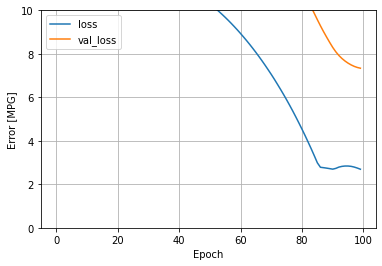

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
  
plot_loss(history)

In [ ]:
test_results = dnn_model.evaluate(test_features, test_labels, verbose=0)

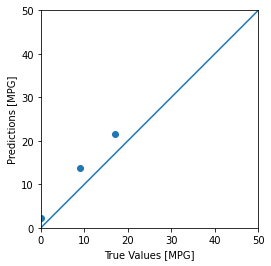

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


In [ ]:
!pip freeze

In [ ]:
from rgbw_colorspace_converter.colors.converters import RGB, HSV, HSL, HSI, Hex
rgb = RGB(255,125,22)

reverse_colors = {}

for r in range(256):
    for g in range(256):
        for b in range(256):
            rgb = RGB(r,g,b)
            
            index = f'{str(rgb.rgbw[0])}-{str(rgb.rgbw[1])}-{str(rgb.rgbw[2])}-{str(rgb.rgbw[3])}'
            
            reverse_colors[index] = (r,g,b)

print(reverse_colors)


In [ ]:


import numpy as np

from ipycanvas import Canvas



width = 9
height = 9

#array = np.zeros([height, width, 3], dtype=np.uint8)
#array[:,:] = [255, 128, 0]


rng = np.random.default_rng()

#array = np.random.random((height, width, 3))

array = rng.integers(255, size=(height, width, 3)).astype(np.uint8)


#im = Image.fromarray((x * 255))

from PIL import Image

#img = Image.fromarray(array)
#img.save('testrgb.png')

#canvas = Canvas(width=800, height=500)

canvas = Canvas(width=array.shape[0], height=array.shape[1])
#canvas.put_image_data(array, 0, 0)

#canvas.fill_style = 'green'
#canvas.fill_rects(x, y, size)

canvas
from io import BytesIO
import base64
from IPython.display import clear_output, display, HTML, Javascript, Image as DImage

global first_draw
first_draw = True

scale = 25

def framebuffer(data, myid="pyrtfb"):
        global first_draw
        im = Image.fromarray(data)
        buffer = BytesIO()
        im.save(buffer, format="PNG")
        img_str = str(base64.b64encode(buffer.getvalue()), encoding="ascii")
        #display(HTML('<img src="data:image/png;base64,' + img_str + '" width="400" height="400" ></img>'), display_id=myid, update=True)
        
        display(
            DImage(data=None, url='data:image/png;base64,' + img_str, filename=None, format=None, embed=None, width=array.shape[0] * scale, height=array.shape[1] * scale, retina=False, unconfined=False, metadata=None), 
            display_id=myid, 
            update=not first_draw,
        )
        first_draw = False
        
        
import time


framebuffer(array)
time.sleep(1)

array = rng.integers(255, size=(height, width, 3)).astype(np.uint8)


#array[:,:] = [255, 128, 0]
framebuffer(array)

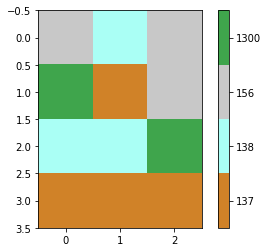

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

a =np.array([[156, 138, 156],
             [1300, 137, 156],
             [138, 138, 1300],
             [137, 137, 137]])

ca = np.array([[156,200,200,200],
               [138,170,255,245],
               [137,208,130,40],
               [1300,63,165,76]])

u, ind = np.unique(a, return_inverse=True)
b = ind.reshape((a.shape))

colors = ca[ca[:,0].argsort()][:,1:]/255.
cmap = matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.BoundaryNorm(np.arange(len(ca)+1)-0.5, len(ca))

plt.imshow(b, cmap=cmap, norm=norm)

cb = plt.colorbar(ticks=np.arange(len(ca)))
cb.ax.set_yticklabels(np.unique(ca[:,0]))

plt.show()

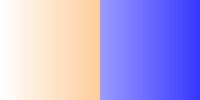

In [ ]:
import numpy as np
from PIL import Image

array = np.zeros([100, 200, 4], dtype=np.uint8)
array[:,:100] = [255, 128, 0, 255] #Orange left side
array[:,100:] = [0, 0, 255, 255]   #Blue right side

# Set transparency depending on x position
for x in range(200):
    for y in range(100):
        array[y, x, 3] = x

img = Image.fromarray(array)
img.save('testrgba.png')
img

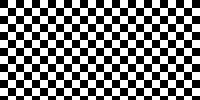

In [ ]:
import numpy as np
from PIL import Image

array = np.zeros([100, 200], dtype=np.uint8)

# Set grey value to black or white depending on x position
for x in range(200):
    for y in range(100):
        if (x % 16) // 8 == (y % 16) // 8:
            array[y, x] = 0
        else:
            array[y, x] = 255

img = Image.fromarray(array)
img.save('testgrey.png')
img

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 8)